In [343]:
from imp import reload
import cProfile

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import cca
import gp

reload(cca)
reload(gp)

<module 'gp' from '/home/davidclark/Projects/ComplexityComponentsAnalysis/gp.py'>

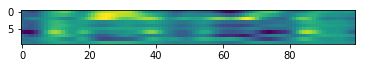

In [354]:
#Make Kernel
K = gp.gen_kernel("squared_exp", spatial_scale=0.5, temporal_scale=5.0)

#Generate 10,000 time-steps in total
T = 500
num_to_concat = 20

#Dimension of ambient space
N = 10

#Dimension of ambient space GP embedding
d = 3

#Noise covariance
noise_spectrum = 0.0000000001*np.ones(N) #np.exp(-np.arange(N)/(N/2))
noise_V = scipy.stats.ortho_group.rvs(N)
noise_cov = np.dot(noise_V, np.dot(np.diag(noise_spectrum), noise_V.T))

#Generate data 
X, E = gp.embed_gp(T, N, d, K, noise_cov, num_to_concat=num_to_concat, return_embedding=True)
plt.imshow(X[:100, :].T)
plt.show()

In [355]:
T_pi = 5

#Get PI of original GP
pi_gp = gp.calc_pi_for_gp(T_pi, d, K)
print("dynamics PI = " + str(np.round(pi_gp, 4)) + " bits")

pi_proj_vals = np.zeros(N+1)
for opt_dim in range(1, N+1):
    V_opt = cca.run_cca(X, T_pi, opt_dim, init="random_ortho", method="L-BFGS-B", verbose=False)
    pi_proj = cca. calc_pi(np.dot(X, V_opt), T_pi)
    print(pi_proj)
    pi_proj_vals[opt_dim] = pi_proj
    
    
    

dynamics PI = 131.2057 bits
12.34442691732699
22.29665671125956
31.675544402305192
31.70234420682912
31.73469485690659
31.759544344915113
31.817037313479926
31.86489975502245
31.93442014926365
31.99588623768996


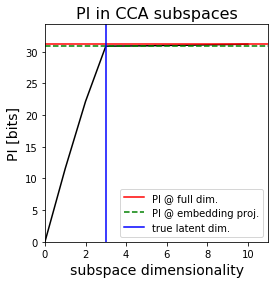

In [353]:
full_pi = cca.calc_pi(X, T_pi)
embedding_pi = cca.calc_pi(np.dot(X, E), T_pi)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(np.arange(N+1), pi_proj_vals, c="black")
plt.axhline(full_pi, label="PI @ full dim.", c="red")
plt.axhline(embedding_pi, label="PI @ embedding proj.", c="green", linestyle="--")
plt.axvline(d, label="true latent dim.", c="blue")

plt.title("PI in CCA subspaces", fontsize=16)
plt.xlabel("subspace dimensionality", fontsize=14)
plt.ylabel("PI [bits]", fontsize=14)

plt.legend()
plt.xlim([0, N*1.1])
plt.ylim([0, np.max(pi_proj_vals)*1.1])

plt.savefig("figs/pi_in_cca_subspaces.pdf", bbox_inches="tight")

In [295]:
type("a") == str

True